# Nevral stiloverføring

## Demo

Install pystiche:

In [7]:
!pip install pystiche

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 KB 748.9 kB/s eta 0:00:00a 0:00:01


Følgende demo er hentet fra: https://docs.pystiche.org/en/latest/galleries/examples/beginner/example_nst_with_pystiche.html#sphx-glr-download-galleries-examples-beginner-example-nst-with-pystiche-py

In [8]:
import pystiche
import torch

from pystiche import demo, enc, loss, optim
from pystiche.image import show_image
from pystiche.misc import get_device, get_input_image

device = get_device()
print(torch.cuda.is_available())
print(f"Device: {device}")

True
Device: cuda


Setter opp multi-layer encoder

In [9]:
multi_layer_encoder = enc.vgg19_multi_layer_encoder()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Setter opp encoder for innhold, samt loss-funksjon.

Setter opp encoder for stil, samt loss-funksjon.

Lager en loss-funksjon som kombinerer innholds- og stil-loss. 

Laster ned demo-bilder.

In [13]:
images = demo.images()
images.download()

Lager en funksjon NST(stilbilde, innholdsbilde).perceptual_loss = loss.PerceptualLoss(content_loss, style_loss).to(device)

In [30]:
def NST(content_image, 
        style_image,
        random_input = False,
        steps = 500,
        content_weight = 1e0, 
        style_weight = 1e3,
        content_layer = "relu4_2",
        style_layers = ("relu1_1", "relu2_1", "relu3_1", "relu4_1", "relu5_1")):
    
    # Create content loss function
    content_encoder = multi_layer_encoder.extract_encoder(content_layer)
    
    content_loss = loss.FeatureReconstructionLoss(content_encoder, 
                                                  score_weight=content_weight)
    
    # Create style loss function
    def get_style_op(encoder, layer_weight):
        return loss.GramLoss(encoder, score_weight=layer_weight)

    style_loss = loss.MultiLayerEncodingLoss(
         multi_layer_encoder, style_layers, get_style_op, score_weight=style_weight)
    
    # Create combined loss function
    perceptual_loss = loss.PerceptualLoss(content_loss, style_loss).to(device)
    
    
    perceptual_loss.set_content_image(content_image)
    perceptual_loss.set_style_image(style_image)
    
    # Set input image
    if random_input:
        starting_point = "random"
    else:
        starting_point = "content"
    
    input_image = get_input_image(starting_point, content_image=content_image)
    
    # Generate NST output image
    output_image = optim.image_optimization(input_image, perceptual_loss, num_steps=steps)
    return output_image

def demo_NST(content_name, style_name):
    size = 500
    content_image = images[content_name].read(size=size, device=device)
    style_image = images[style_name].read(size=size, device=device)
    return NST(content_image, style_image)

## Testing av NST

Først skriver vi ut alle demobildene vi bruker:

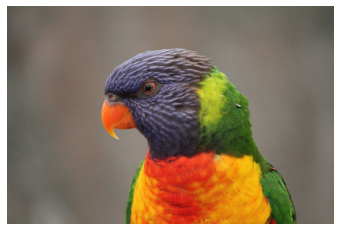

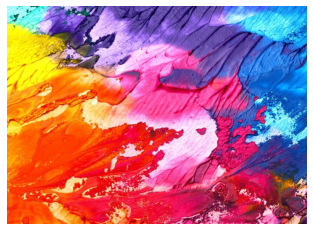

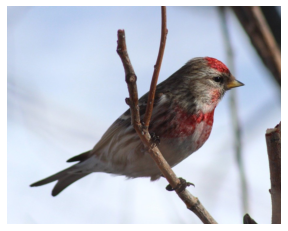

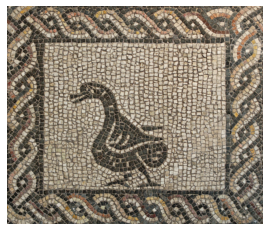

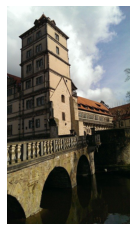

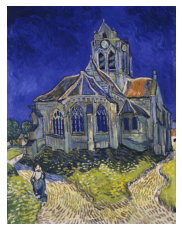

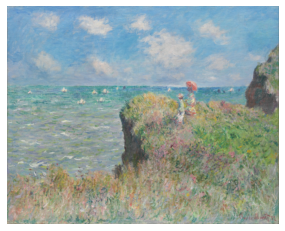

In [16]:
img_names = ["bird1", "paint", "bird2", "mosaic", "castle", "church", "cliff"]
for name in img_names:
    show_image(images[name].read(size=size, device=device))

### Bilder med standardkonfigurasjon

Vi prøver forskjellige bilder med standardkonfigurasjonen:

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

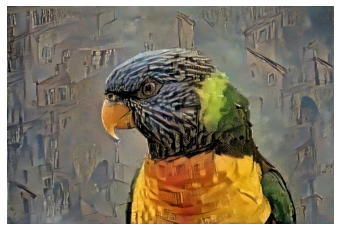

In [24]:
show_image(demo_NST("bird1", "castle"))

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

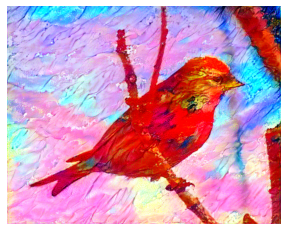

In [19]:
show_image(demo_NST("bird2", "paint"))

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

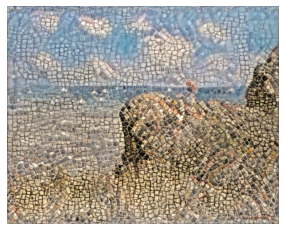

In [20]:
show_image(demo_NST("cliff", "mosaic"))

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

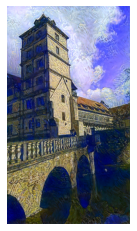

In [25]:
show_image(demo_NST("castle", "church"))

### Bilder i forskjellige størrelser

Vi bruker standardkonfigurasjonen, bortsett fra at vi bruker 4 forskjellige bildestørrelser: 100, 300, 500, 800. Det vil si at antall steg er konstant for alle 4 bildene. Vi bruker bird1 som innhold og paint som stilbilde.

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

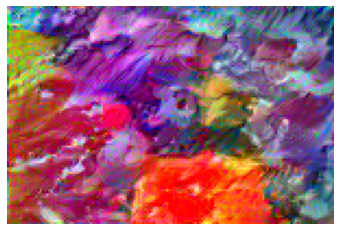

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

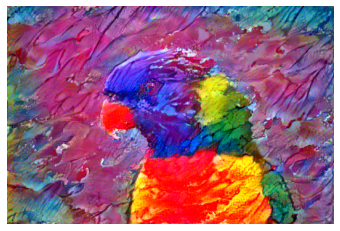

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

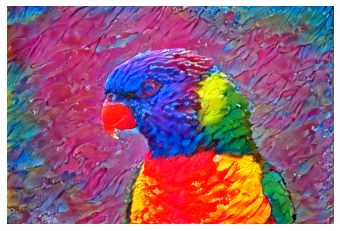

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

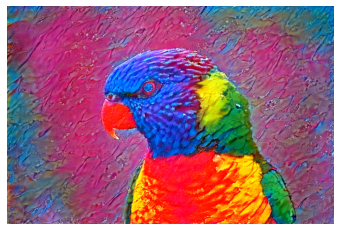

In [29]:
sizes = (100, 300, 500, 800)
for size in sizes:
    content_image = images["bird1"].read(size=size, device=device)
    style_image = images["paint"].read(size=size, device=device)
    show_image(NST(content_image, style_image))
    

Bildene blir mer detaljerte med høyere oppløsning, som gir mening.

### Bilder med forskjellig antall steg

Vi bruker NST med samme bilder og standardoppsettet, bortsett fra at vi endrer antall steg: vi prøver 31, 62, 125, 250, 500, 1000 steg.

Image optimization:   0%|          | 0/31 [00:00<?, ?it/s]

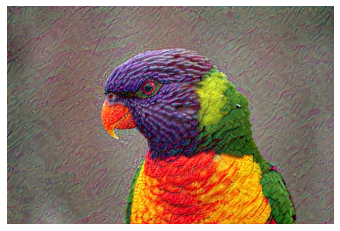

Image optimization:   0%|          | 0/62 [00:00<?, ?it/s]

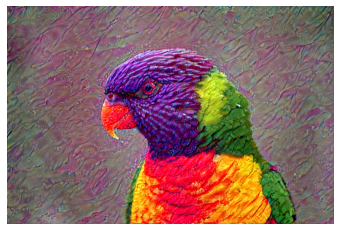

Image optimization:   0%|          | 0/125 [00:00<?, ?it/s]

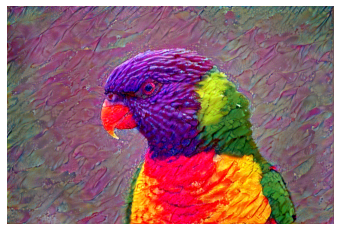

Image optimization:   0%|          | 0/250 [00:00<?, ?it/s]

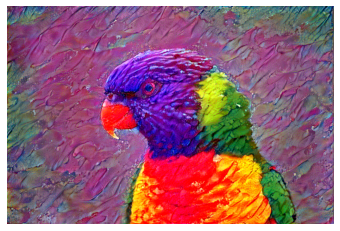

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

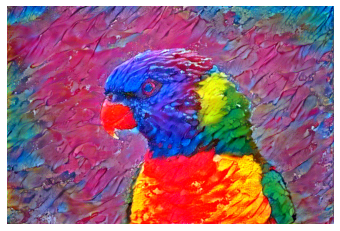

Image optimization:   0%|          | 0/1000 [00:00<?, ?it/s]

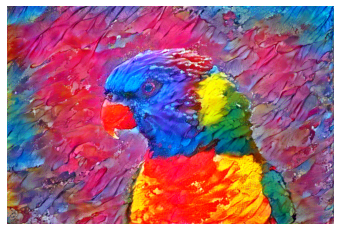

In [32]:
size = 500
content_image = images["bird1"].read(size=size, device=device)
style_image = images["paint"].read(size=size, device=device)

step_list = (31, 62, 125, 250, 500, 1000)

for steps in step_list:
    show_image(NST(content_image, style_image, steps=steps))

Vi ser at bildet gradvis får en stil som likner bildet paint, desto flere steg algoritmen tar. I starten ligner imidlertid bildet veldig på innholdsbildet. Dette gir mening, da vi starter med innholdsbilde, og gradvis endrer bildet slik at det får stil liknende stilbildet. Vi merker oss at det både tar lengre tid, og at loss-funksjonen får til å få lavere verdi, når vi øker antall steg.

### Forskjellige vektinger av innhold og stil

Vi bruker de samme bildene, men velger denne gangen å variere vektingen mellom innhold og stil. Vi holder innholdsvektingen konstant på 1, men prøver med stilvekting på 1e0, 1e1, 1e2, 1e3:

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

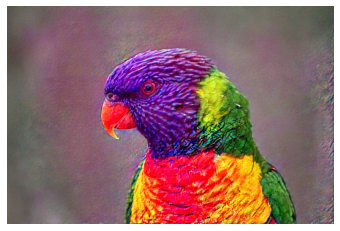

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

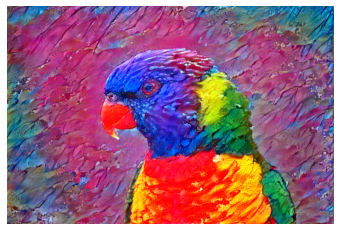

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

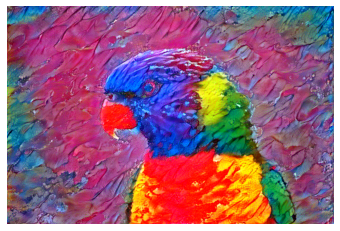

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

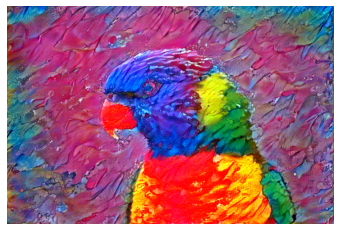

In [34]:
size = 500
content_image = images["bird1"].read(size=size, device=device)
style_image = images["paint"].read(size=size, device=device)

style_weights = (1e0, 1e2, 1e4, 1e6)

for style_weight in style_weights:
    show_image(NST(content_image, style_image, style_weight=style_weight))

## Hva hvis vi fjerner innholdsbildet?

Nå ønsker vi å se på effekten av å sette innholdsvektingen til null og starte med tilfeldig støy som input.

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

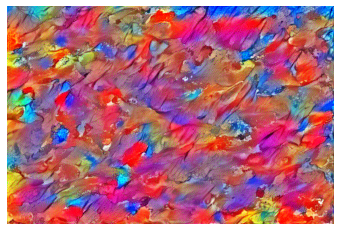

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

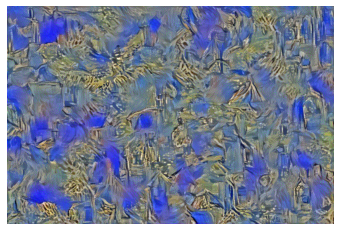

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

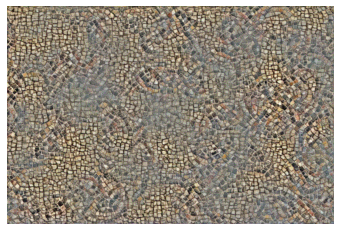

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

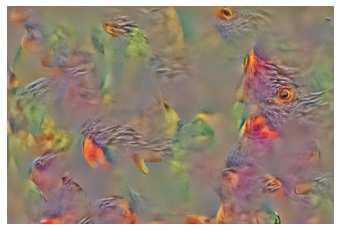

In [35]:
size = 500
stylenames = ["paint", "church", "mosaic", "bird1"]
for stylename in stylenames:
    content_image = images["bird1"].read(size=size, device=device)
    style_image = images[stylename].read(size=size, device=device)
    show_image(NST(content_image, style_image, content_weight=0, random_input = True))

We repeat the same with fewer style layers:

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

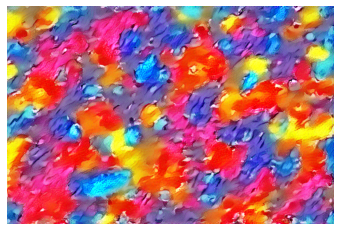

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

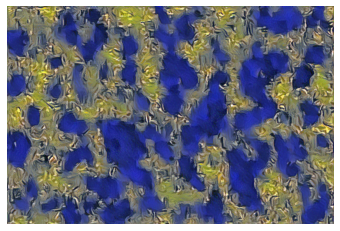

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

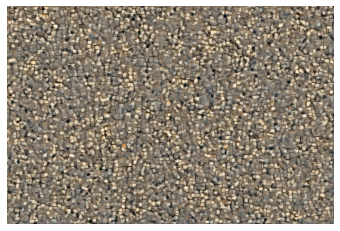

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

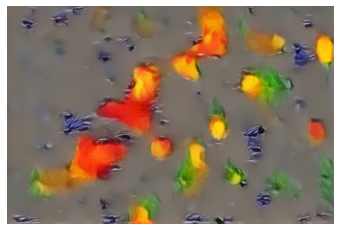

In [36]:
style_layers = ("relu1_1", "relu2_1")
for stylename in stylenames:
    content_image = images["bird1"].read(size=size, device=device)
    style_image = images[stylename].read(size=size, device=device)
    show_image(NST(content_image, style_image, content_weight=0, random_input = True, 
                   style_layers=style_layers))

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

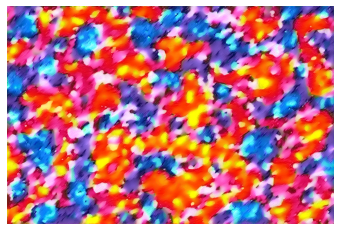

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

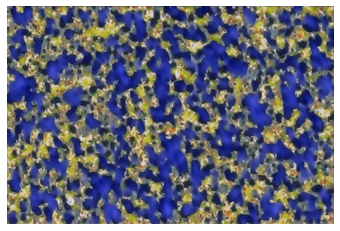

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

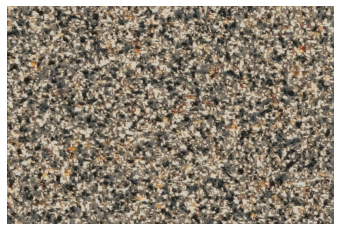

Image optimization:   0%|          | 0/500 [00:00<?, ?it/s]

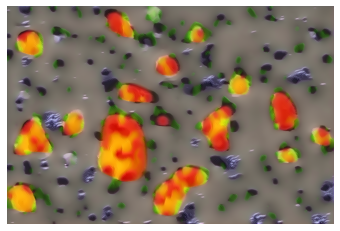

In [37]:
style_layers = ("relu1_1",)
for stylename in stylenames:
    content_image = images["bird1"].read(size=size, device=device)
    style_image = images[stylename].read(size=size, device=device)
    show_image(NST(content_image, style_image, content_weight=0, random_input = True, 
                   style_layers=style_layers))

Vi ser færre detaljer i bildene som produseres med færre lag. 

TODO: Forklaring. Ideen er noe som at flere lag til sammen kan skape mer avanserte, distinkte mønstre, flere filtre oppå hverandre kan inneholde mye informasjon. Vi ser bl.a. noe som ser ut som nebb og øyne fra bird1 på bildet med 4 lag, mens det er mye vanskeligere å gjenkjenne deler av fuglen på bildet med 1 eller 2 stillag.